Notizen:

MC Dropout mit nur epistemic Uncertainty: overconfident, trainiert mit MSE

MC Dropout mit aleatoric(tau, lengthscale) (homoscedastic) und epistemic: underconfident, erst trainiert mit MSE und dann NLL, manuelle Anpassung von tau, dann besser, 500 Samples bricht Kernel immer ab?!

MC Dropout heteroscedastic beste Variante?! Network sagt mean und variance pro input voraus, implementiert, von R² Score am schlechtesten, etwas zu unsicher

Optuna: mein Gefühl, manchmal zu schnell in einem loss Valley, dann bleibt es dort bzw. sucht in diesem nach guten kombinationen, globales Optimum erreichbar?!

Necessary imports

In [1]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score

# check the computer name and set the path accordingly
if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':      # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])
import utils.data_prep as data_prep
import utils.metrices as metrices


Load, Transform and Split the data

In [ ]:


#load and transform the data, split it into training, validation, and test sets
# the split ratio is 60% training, 20% validation, and 20%
# return the feature names for later use
X_train, X_val, X_test, y_train, y_val, y_test, feature_names = data_prep.load_tranform_and_split_data('C1_V01_delta_kan', split_ratio=(0.6, 0.2, 0.2))

# convert the data to PyTorch tensors
# and add an extra dimension for the target variable
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float().reshape(-1,1) # Add extra dimension for compatibility
y_val_tensor = torch.from_numpy(y_val).float().reshape(-1,1)
y_test_tensor = torch.from_numpy(y_test).float().reshape(-1,1)
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
print(feature_names)
print(y_train_tensor.shape, y_val_tensor.shape, y_test_tensor.shape)

torch.Size([31206, 37]) torch.Size([10402, 37]) torch.Size([10403, 37])
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')
torch.Size([31206, 1]) torch.Size([10402, 1]) torch.Size([10403, 1])


Hyperparameter Search with Optuna for network architecture

https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py#L93

https://www.youtube.com/watch?v=P6NwZVl8ttc


In [ ]:
import optuna
import utils.NN_model as NN_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
 
    # hyperparameter for sampling with Optuna
    n_layer = trial.suggest_int("n_layer", 2, 4)  # number of hidden layers
    n_neurons = trial.suggest_int("n_neurons", 32, 256, step=32)  # number of neurons in each hidden layer
    do_rate = trial.suggest_float("do_rate", 0.05, 0.5)     # dropout rate 
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)    # learning rate
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256]) 
    
    # decay factor for the number of neurons in each layer
    # e.g. if n_neurons = 256 and n_layer = 3
    # then the hidden_dims will be [256, 128, 64]
    decay = 0.5
    # this creates a list of integers representing the number of neurons in each hidden layer
    hidden_dims = [int(n_neurons * decay**i) for i in range(n_layer)]
    print(f"Hidden dimensions: {hidden_dims}")
        
    # generate the model with the sampled hyperparameters
    # and move it to the device (GPU or CPU)
    model = NN_model.Custom_NN_Model(
        input_dim=X_train_tensor.shape[1],
        hidden_dims=hidden_dims,
        output_dim=1,
        do_rate=do_rate,
        loss_type = None
    ).to(device)

    # AdamW optimizer, where weight decay does not accumulate in the momentum nor variance.
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = lr, weight_decay=0.0001)  

    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # integrate early stopping
    patience = 20  # number of epochs with no improvement after which training will be stopped
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # training the model
    for epoch in range(epochs):
        model.train()
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)  # Move data to the device (GPU or CPU)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = torch.nn.functional.mse_loss(output, y_batch)
            loss.backward()
            optimizer.step()
            
        # validation loss calculation after each epoch
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = torch.nn.functional.mse_loss(y_val_pred, y_val_tensor).item()
            
        trial.report(val_loss, step=epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            #print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}, Best Val Loss: {best_val_loss:.4f}")
                break
    
    return best_val_loss


c:\Users\test\Masterarbeit\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Execute Optuna Study

In [ ]:
from optuna.trial import TrialState

# define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# number of epochs for training
epochs = 500

# create a study object for Optuna
study = optuna.create_study(
    #study_name="MC_Dropout_Optuna_Network_architecture",
    #storage="sqlite:///mc_dropout_study.db",                    # Use SQLite database to store the
    #load_if_exists=True,                                        # load the study if it already exists
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),                       #TPE (Tree-structured Parzen Estimator) sampler by default
    pruner=optuna.pruners.MedianPruner(        
        n_startup_trials=10,                                    # Number of trials to run before pruning starts
        n_warmup_steps=5                                        # Number of warmup steps before pruning starts)
    )
)

# move the tensors to the device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# optimize the objective function with Optuna
# timeout=None means no time limit for the optimization, all trials will be run
study.optimize(objective, n_trials=100, timeout=None, n_jobs=1, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
# selcet Device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import utils.NN_model as NN_model


# Move training and val data  to device
X_train_tensor = X_train_tensor.to(device)  
X_val_tensor = X_val_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# Create model instance with best parameters and move to device
model_mse = NN_model.Custom_NN_Model(input_dim=X_train.shape[1], hidden_dims=[160, 80, 40], output_dim=1, do_rate=0.14).to(device)  # Create model instance and move to device
# Train the model with the best parameters
optimizer = torch.optim.AdamW(params=model_mse.parameters(), lr=0.0025, weight_decay=0.0001)  # Use AdamW optimizer with specified learning rate and weight decay
tr_model_mse = NN_model.train_model(model_mse, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, batch_size=64, n_epochs=1000, optimizer= optimizer, patience=20, loss_type='mse', device = device)

Using device: cuda
Epoch 1/1000, Train Loss: 773.3831, Val Loss: 31.7394, Best Val Loss: 31.7394
Epoch 3/1000, Train Loss: 166.1400, Val Loss: 28.6972, Best Val Loss: 28.6972
Epoch 5/1000, Train Loss: 164.7304, Val Loss: 22.5419, Best Val Loss: 22.5419
Epoch 15/1000, Train Loss: 121.7599, Val Loss: 22.0341, Best Val Loss: 22.0341
Epoch 16/1000, Train Loss: 121.8495, Val Loss: 20.1087, Best Val Loss: 20.1087
Epoch 19/1000, Train Loss: 108.0953, Val Loss: 19.1249, Best Val Loss: 19.1249
Epoch 21/1000, Train Loss: 103.9504, Val Loss: 19.1098, Best Val Loss: 19.1098
Epoch 23/1000, Train Loss: 97.4340, Val Loss: 17.9894, Best Val Loss: 17.9894
Epoch 24/1000, Train Loss: 95.4102, Val Loss: 17.4356, Best Val Loss: 17.4356
Epoch 27/1000, Train Loss: 88.9438, Val Loss: 16.2726, Best Val Loss: 16.2726
Epoch 29/1000, Train Loss: 85.1516, Val Loss: 15.9497, Best Val Loss: 15.9497
Epoch 32/1000, Train Loss: 81.5372, Val Loss: 15.0786, Best Val Loss: 15.0786
Epoch 35/1000, Train Loss: 76.7846, Val L

Inference on the Train and test data with only epistemic uncertainty

In [11]:
# inference with multiple forward passes
# keep the model in training mode to keep dropout active
tr_model_mse.train()
tr_model_mse.to('cpu')  # Ensure the model is on the correct device
X_tr = X_train_tensor.to('cpu')  # Ensure the input data is on the correct device
X_te = X_test_tensor.to('cpu')  # Ensure the test data is on the correct device
# Number of stochastic forward passes for MC Dropout
n_samples = 250

# Make multiple stochastic predictions (MC Dropout) on the train data
y_train_pred_mse = torch.stack([tr_model_mse(X_tr) for i in range(n_samples)]).detach().cpu().numpy() #list comprehension for the number of stochastic forward passes for MC Dropout

# Make multiple stochastic predictions (MC Dropout) on the test data
y_test_pred_mse = torch.stack([tr_model_mse(X_te) for i in range(n_samples)]).detach().cpu().numpy()

Plot the uncertainty interval for the NN with MC Dropout

R² on Train Data: 0.881
R² on Test Data: 0.856
empistemic variance 2.276867151260376
(10403,) (10403,)
Mean of std: 1.438075304031372 Std of std: 0.4569539725780487
Number of true values within the confidence interval: 7680 out of 10403
Coverage: 73.82%


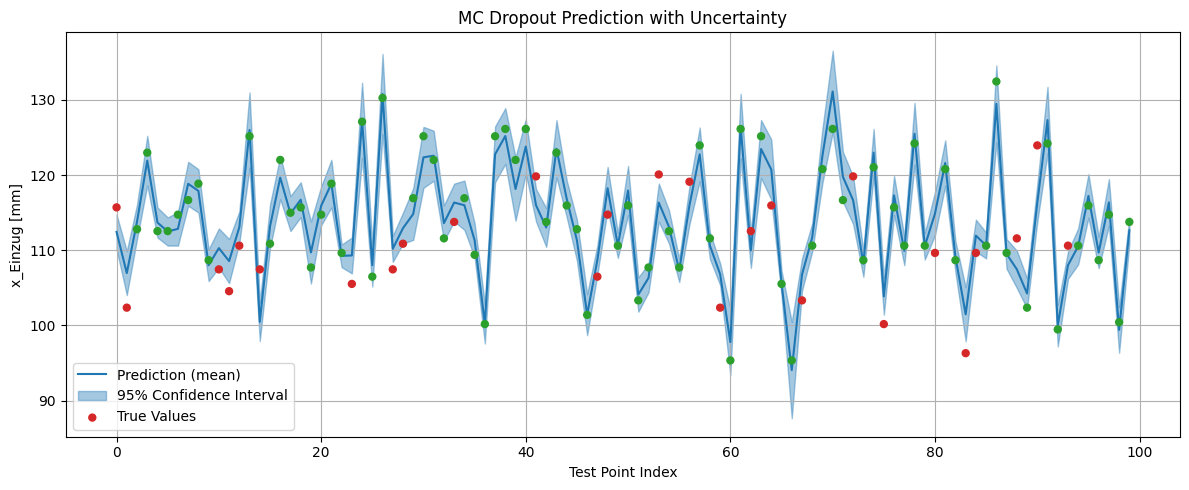

In [12]:
#! handling the train data
# Calculate the mean and standard deviation of the predictions on the train data
y_train_pred_mean = y_train_pred_mse.mean(axis = 0)
y_train_Pred_std = y_train_pred_mse.std(axis = 0)

# Calculate R² score on the train data
r2_train = r2_score(y_train, y_train_pred_mean)
print(f"R² on Train Data: {r2_train:.3f}")

#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_te), num_points, replace=False)
random_indices.sort()

# Calculate the mean and standard deviation of the predictions on the test data
y_test_pred_mean = y_test_pred_mse.mean(axis = 0)
y_test_pred_std = y_test_pred_mse.std(axis = 0)

# Calculate R² score for the test data
r2_test = r2_score(y_test_tensor.cpu(), y_test_pred_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# Assign descriptive variable names for MC Dropout mean and standard deviation
mc_mean = y_test_pred_mean.flatten()  # Predicted mean for each test point
mc_std = y_test_pred_std.flatten()    # Predicted standard deviation for uncertainty
print(f'empistemic variance {y_test_pred_mse.var(axis = 0).mean()}')
print(mc_mean.shape, mc_std.shape)
print(f'Mean of std: {mc_std.mean()} Std of std: {mc_std.std()}')

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
mc_lower_bound = mc_mean - 2 * mc_std
mc_upper_bound = mc_mean+ 2 * mc_std

# calculate the coverage of the confidence interval
in_interval = (y_test >= mc_lower_bound) & (y_test <= mc_upper_bound)
# number of true
counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= mc_lower_bound[random_indices]) & (y_test[random_indices] <= mc_upper_bound[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, mc_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound[random_indices], mc_upper_bound[random_indices], alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_test_tensor[random_indices].cpu().flatten(), label="True Values", c=colors, s=25, zorder=3)

# Final plot settings
plt.title("MC Dropout Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#! schlechte Coverage weil nur epistemic uncertainty is modeled?!
#! The model is trained with dropout, but the uncertainty estimation is not perfect.

Optuna Hyperparameter Search for legthscale and tau Homoscedastic

In [ ]:
import optuna
def objective(trial):

    # number of stochastic forward passes for MC Dropout
    n_samples = 50  

    # fixed hyperparameters for simplicity
    hidden_dims = [160, 80, 40]  #! Use fixed hidden dimensions for simplicity
    lr = 0.0025  #! learning rate
    batch_size = 64  #! batch size
 
    # hyperparameter for sampling with Optuna
    tau = trial.suggest_float("tau", 0.01, 10.0, log=True)   
    lengthscale = trial.suggest_float("lengthscale", 1e-4, 1.0, log=True) 
    do_rate = trial.suggest_float("do_rate", 0.05, 0.3)     # dropout rate adjust range according to first run 

    N = X_train_tensor.shape[0]  # number of training samples
    # weight decay 
    weight_decay = lengthscale**2 * (1 - do_rate) / (2 * N * tau)  # Adjusted weight decay according to paper

    # generate the model with the sampled hyperparameters
    # and move it to the device (GPU or CPU)
    model = NN_model.Custom_NN_Model(
        input_dim=X_train_tensor.shape[1],
        hidden_dims= hidden_dims,
        output_dim=1,
        do_rate=do_rate
    ).to(device)

    # AdamW optimizer, where weight decay does not accumulate in the momentum nor variance.
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = lr, weight_decay=weight_decay)  

    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # integrate early stopping
    patience = 20  # number of epochs with no improvement after which training will be stopped
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # training the model
    for epoch in range(epochs):
        model.train()
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)  # Move data to the device (GPU or CPU)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = torch.nn.functional.mse_loss(output, y_batch)
            loss.backward()
            optimizer.step()
            
        # validation loss calculation after each epoch
        model.train()  # Set model to training mode for MC Dropout predcition
        with torch.no_grad():
            y_val_preds = torch.stack(
                [model(X_val_tensor) for _ in range(n_samples)]
            )

            #mc_val_pred_mean = y_val_preds.mean(axis=0)
            #mc_val_pred_std = y_val_preds.std(axis=0)

            # compute the negative log liklihood
            ll_val_loss = (torch.logsumexp(-0.5 * tau * (y_val_tensor[None] - y_val_preds)**2, 0) - np.log(n_samples)
                            - 0.5 * np.log(2 * np.pi) - 0.5 * np.log(tau))
            nll_val_loss = - ll_val_loss.mean()
        

        # Early stopping check
        # If the validation loss is lower than the best validation loss, update the best validation loss
        if nll_val_loss < best_val_loss:
            best_val_loss = nll_val_loss
            epochs_no_improve = 0
            print(f"Epoch {epoch+1}/{epochs}, NLL Val Loss: {nll_val_loss:.4f}, Best NLL Val Loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break  # Early stopping

        trial.report(nll_val_loss, step=epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    return best_val_loss


In [ ]:
from optuna.trial import TrialState

# define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# number of epochs for training
epochs = 200

# create a study object for Optuna
study = optuna.create_study(
    #study_name="MC_Dropout_Optuna_Network_architecture",
    #storage="sqlite:///mc_dropout_study.db",                    # Use SQLite database to store the
    #load_if_exists=True,                                        # load the study if it already exists
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),                       #TPE (Tree-structured Parzen Estimator) sampler by default
    pruner=optuna.pruners.MedianPruner(        
        n_startup_trials=10,                                    # Number of trials to run before pruning starts
        n_warmup_steps=5                                        # Number of warmup steps before pruning starts)
    )
)

# move the tensors to the device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# optimize the objective function with Optuna
# timeout=None means no time limit for the optimization, all trials will be run
study.optimize(objective, n_trials=25, timeout=None, n_jobs=1, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Training and Inference of MC Dropout with tau and lengthscale from Optuna

In [ ]:
# selcet Device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move training and val data  to device
X_train_tensor = X_train_tensor.to(device)  
X_val_tensor = X_val_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

lengthscale = 0.26203793385581947 #trial.params['lengthscale']
tau =  0.15 # trial.params['tau']
do_rate = 0.27 #trial.params['do_rate']

print(f' lengtscale {lengthscale} tau {tau} dropout_rate {do_rate}')
N = X_train_tensor.shape[0]  # number of training samples
# weight decay 
weight_decay = lengthscale**2 * (1 - do_rate) / (2 * N * tau)  # Adjusted weight decay according to paper
print(f"Weight Decay: {weight_decay:.6f}")

# Create model instance with best parameters and move to device
model_homoscedastic = NN_model.Custom_NN_Model(input_dim=X_train.shape[1], hidden_dims=[160, 80, 40], output_dim=1, do_rate=do_rate).to(device)  # Create model instance and move to device
# Train the model with the best parameters
optimizer_homoscedastic = torch.optim.AdamW(params=model_homoscedastic.parameters(), lr=0.0025, weight_decay=weight_decay)  # Use AdamW optimizer with specified learning rate and weight decay
tr_model_homoscedastic = NN_model.train_model(model_homoscedastic, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, batch_size=64, n_epochs=1000, optimizer = optimizer_homoscedastic, patience=20)

Using device: cuda
 lengtscale 0.26203793385581947 tau 0.15 dropout_rate 0.27
Weight Decay: 0.000005
Epoch 1/1000, Train Loss: 1120.3593, Val Loss: 34.4641, Best Val Loss: 34.4641
Epoch 4/1000, Train Loss: 400.5020, Val Loss: 34.4476, Best Val Loss: 34.4476
Epoch 5/1000, Train Loss: 389.8617, Val Loss: 26.5154, Best Val Loss: 26.5154
Epoch 13/1000, Train Loss: 297.4604, Val Loss: 22.3684, Best Val Loss: 22.3684
Epoch 21/1000, Train Loss: 232.0143, Val Loss: 22.3305, Best Val Loss: 22.3305
Epoch 25/1000, Train Loss: 206.7051, Val Loss: 21.9804, Best Val Loss: 21.9804
Epoch 26/1000, Train Loss: 206.4959, Val Loss: 18.8421, Best Val Loss: 18.8421
Epoch 35/1000, Train Loss: 166.0116, Val Loss: 17.5816, Best Val Loss: 17.5816
Epoch 41/1000, Train Loss: 150.9539, Val Loss: 16.3682, Best Val Loss: 16.3682
Epoch 45/1000, Train Loss: 131.6210, Val Loss: 13.8072, Best Val Loss: 13.8072
Epoch 58/1000, Train Loss: 99.7520, Val Loss: 13.2481, Best Val Loss: 13.2481
Epoch 63/1000, Train Loss: 91.053

In [22]:
# inference with multiple forward passes
# keep the model in training mode to keep dropout active
tr_model_homoscedastic.train()
tr_model_homoscedastic.to('cpu')  # Ensure the model is on the correct device
X_tr = X_train_tensor.to('cpu')  # Ensure the input data is on the correct device
X_te = X_test_tensor.to('cpu')  # Ensure the test data is on the correct device
# Number of stochastic forward passes for MC Dropout
n_samples = 250

# Make multiple stochastic predictions (MC Dropout) on the train data
y_train_pred_homoscedastic = torch.stack([tr_model_homoscedastic(X_tr) for i in range(n_samples)]).detach().cpu().numpy() #list comprehension for the number of stochastic forward passes for MC Dropout

# Make multiple stochastic predictions (MC Dropout) on the test data
y_test_pred_homoscedastic = torch.stack([tr_model_homoscedastic(X_te) for i in range(n_samples)]).detach().cpu().numpy()

[[114.51461]
 [107.81487]
 [121.38024]
 [125.41871]
 [110.81957]]
[114.7258 106.48   121.0372 129.2826 113.5077]
R² on Train Data: 0.853
Epistemic Variance: 3.034068
Aleatoric Variance: 6.666667
Total Standard Deviation: 3.094565
R² on Test Data: 0.836
Negative Log Likelihood (NLL) on Test Data: -2.523
shape of mc_lower_bound (10403,) mc_upper_bound (10403,)
Number of true values within the confidence interval: 9931 out of 10403
Coverage: 95.46%


C:\Users\test\AppData\Local\Temp\ipykernel_15032\2346355009.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ll = (torch.logsumexp(-0.5 * tau * (y_test_tensor.cpu()[None] - y_test_pred_homoscedastic)**2,0)  # calculate log likelihood according to the paper


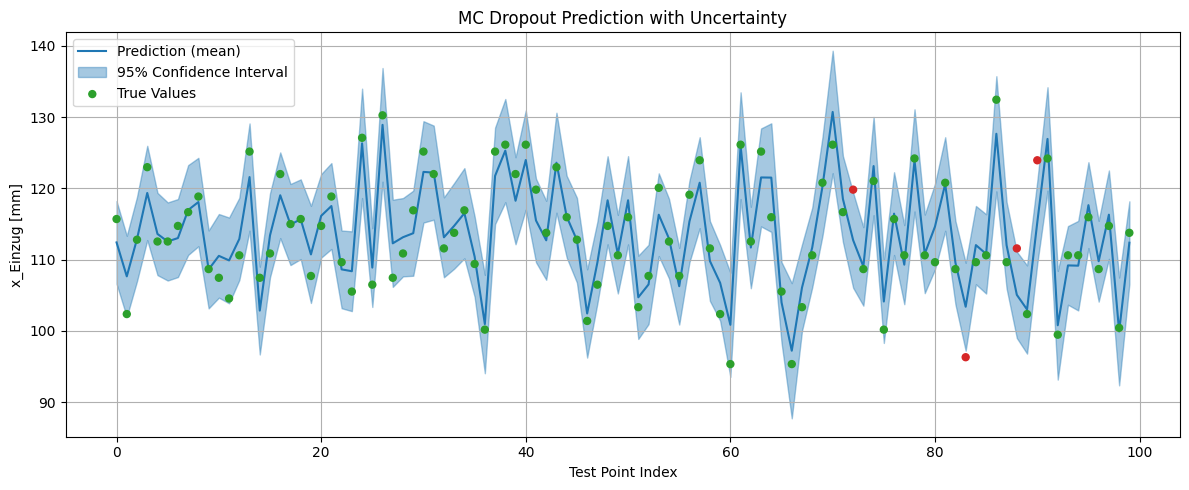

In [ ]:
#! handling the train data
# Calculate the mean and standard deviation of the predictions on the train data
y_train_pred_mean = y_train_pred_homoscedastic.mean(axis = 0)
y_train_Pred_std = y_train_pred_homoscedastic.std(axis = 0)
print(y_train_pred_mean[:5])
print(y_train[:5])
# Calculate R² score on the train data
r2_train = r2_score(y_train, y_train_pred_mean)
print(f"R² on Train Data: {r2_train:.3f}")

#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_te), num_points, replace=False)
random_indices.sort()

# Calculate the mean and standard deviation of the predictions on the test data
y_test_pred_mean = y_test_pred_homoscedastic.mean(axis = 0)

epistemic_var = y_test_pred_homoscedastic.var(axis=0)
print(f"Epistemic Variance: {epistemic_var.mean():.6f}")

# Step 2: Addiere aleatorische Varianz (1/tau) wie im Paper
aleatoric_var = 1 / tau
print(f"Aleatoric Variance: {aleatoric_var:.6f}")
total_std = np.sqrt(epistemic_var + aleatoric_var)
print(f"Total Standard Deviation: {total_std.mean():.6f}")

# Ersetze y_test_pred_std durch total_std
y_test_pred_std = total_std

# Calculate R² score for the test data
r2_test = r2_score(y_test_tensor.cpu(), y_test_pred_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# calculate NLL for the test data
ll = (torch.logsumexp(-0.5 * tau * (y_test_tensor.cpu()[None] - y_test_pred_homoscedastic)**2,0)  # calculate log likelihood according to the paper
      -np.log(n_samples) - 0.5 * np.log(2*np.pi) + 0.5 * np.log(tau))
test_ll = ll.mean()  # Mean Log Likelihood
test_ll = test_ll.to('cpu')  # Move to CPU for printing
nll = -test_ll
print(f"Negative Log Likelihood (NLL) on Test Data: {test_ll:.3f}")


# Assign descriptive variable names for MC Dropout mean and standard deviation
mc_mean = y_test_pred_mean.flatten()  # Predicted mean for each test point
mc_std = y_test_pred_std.flatten()    # Predicted standard deviation for uncertainty

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
mc_lower_bound = mc_mean - 2 * mc_std
mc_upper_bound = mc_mean+ 2 * mc_std

print(f'shape of mc_lower_bound {mc_lower_bound.shape} mc_upper_bound {mc_upper_bound.shape}')
# calculate the coverage of the confidence interval
in_interval = (y_test >= mc_lower_bound) & (y_test <= mc_upper_bound)
# number of true
counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= mc_lower_bound[random_indices]) & (y_test[random_indices] <= mc_upper_bound[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, mc_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound[random_indices], mc_upper_bound[random_indices], alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_test_tensor[random_indices].cpu().flatten(), label="True Values", c=colors, s=25, zorder=3)

# Final plot settings
plt.title("MC Dropout homoscedastic Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[6873 5130 6255 ...  402 3043 1975]
[ 65.      81.7435  83.9345 ... 127.3499 127.3499 127.3499]
Lowest of mc_lower_bound_full: 89.7096
Highest of mc_upper_bound_full: 141.4293
Highest difference between mc_lower_bound_full and mc_upper_bound_full: 25.7839
Index of highest difference: 3941


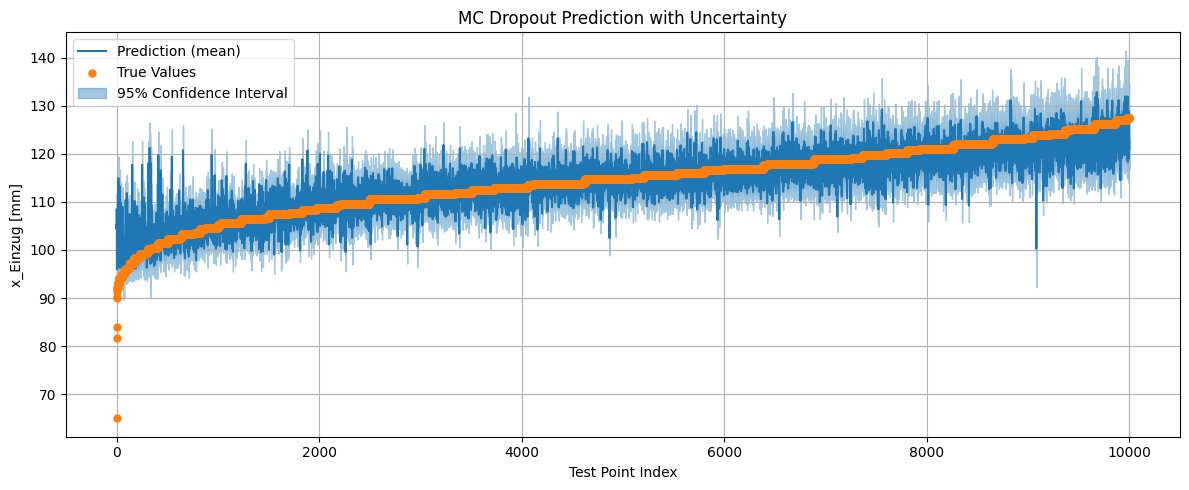

In [64]:
sort_idx = np.argsort(y_test_tensor.cpu().flatten().numpy())
print(sort_idx)
# Sort the predictions and standard deviations for the first 1000 points    
mc_mean_sorted = mc_mean[sort_idx]
mc_std_sorted = mc_std[sort_idx]
y_test_sorted = y_test_tensor.cpu().flatten().numpy()[sort_idx]

n = 10000

mc_mean_sorted = mc_mean_sorted[:n]
mc_std_sorted = mc_std_sorted[:n]   
y_test_sorted = y_test_sorted[:n]

print(y_test_sorted)

mc_lower_bound_full = mc_mean_sorted - 2 * mc_std_sorted
mc_upper_bound_full = mc_mean_sorted + 2 * mc_std_sorted
# print lower of mc_lower_bound_full and highest of mc_upper_bound_full
print(f"Lowest of mc_lower_bound_full: {mc_lower_bound_full.min():.4f}")
print(f"Highest of mc_upper_bound_full: {mc_upper_bound_full.max():.4f}")

#print the highes difference between mc_lower_bound_full and mc_upper_bound_full and the index of the highest difference
diff = mc_upper_bound_full - mc_lower_bound_full
print(f"Highest difference between mc_lower_bound_full and mc_upper_bound_full: {diff.max():.4f}")
print(f"Index of highest difference: {np.argmax(diff)}")

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(n)  # Create an index axis for plotting
# Plot the predicted mean
plt.plot(mc_mean_sorted, label="Prediction (mean)", color='tab:blue')

# plot true values for the first 100 points
plt.scatter(x_axis, y_test_sorted, label="True Values", c='tab:orange', s=25, zorder=3)

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound_full, mc_upper_bound_full, alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')
# Final plot settings
plt.title("MC Dropout Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()